<a href="https://colab.research.google.com/github/AgroFed/fl/blob/main/src/shap/Target_Model_Smile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [ ]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
#!wget --header="Host: doc-04-00-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.80 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9,hi-IN;q=0.8,hi;q=0.7" --header="Cookie: AUTH_m80r6ac3e0npo2l9pber69cs9gdi4a7e=05646759521610636064|1645424250000|r1fop1mkbe3qa8gao9nl3s889j58sesu" --header="Connection: keep-alive" "https://doc-04-00-docs.googleusercontent.com/docs/securesc/8jf050idp65d2ed88p5mkav85vhgep2c/4vrirnms6ker4cmjhhj9t516nm54qusg/1645424325000/05646759521610636064/05646759521610636064/1R4aJxsWSUcJhN61WMDMi79TumFxHZQss?e=download&ax=ACxEAsYed5cpyvEXqgxcX9vJoaqO0SrlBe-GHfCD0cH8vqbFmDOfzFKXfrf1S8u-O1EDn2iU6HchcmkQcWWOT-099q7xfyxGCFypKNmv2FQnQ698y0E37e3srt6xlQgyPf1G1_uosSoeheuOuw32fBgzHSoLtkbIL_b6s5wk5p6VX2IJKldOfa-m4lSnS766jc5wC0A8LfvA8FPEmzqu-jec_27Xevrvicpq-m5k2bKAfYZYXKD8inTehI4ZPLNUxehChNXgZoNANX8a55kmTsVYTF05qKC0yiG_-o8L0aHeNAfem05RtLT5Yc7n0usGlzwjmQwhNWvx5c3-D5oCsKKpA93DTdvsC2w_kJf8Mmz9FohijBfIAfD1inWHDxwV8AydGywQVLkEgC86EzazInSD9o0U5htNxdeNqfpHOWHIL0Xa21qE_vXb2dh2zo1IFod11Vr780y9pJCOoNRH0VsFndRpDmYyiSyfTDDjxqN0bOMFdWE0gL_HuMlP4YoY5hFWsruArwyiIl7ADAF88wXrBi-rmvRC1UMrKaJ7AWlu1YtfVTrVdEfkRtlYeIdIDmqS_hHBNkkuKp5VyoYZRtHHrcfXdYzf6rJncw3CwWHLOzKfyp636zasA_RfmudSe9TE1wbM6QJSD2GFZ-x7kXjQxex2l7wTSC8SuA&authuser=0" -c -O 'list_attr_celeba.txt'
#!wget --header="Host: doc-0g-00-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.80 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9,hi-IN;q=0.8,hi;q=0.7" --header="Cookie: AUTH_m80r6ac3e0npo2l9pber69cs9gdi4a7e=05646759521610636064|1645424250000|r1fop1mkbe3qa8gao9nl3s889j58sesu" --header="Connection: keep-alive" "https://doc-0g-00-docs.googleusercontent.com/docs/securesc/8jf050idp65d2ed88p5mkav85vhgep2c/d6j6dhgvq3aq448lbd0q2r3868f9nd42/1645424475000/05646759521610636064/05646759521610636064/1OAzS7SMzQfrJLUvywSeQKU_g-4fIxo7a?e=download&ax=ACxEAsZ_y8dsnSQScExHnbQEZbYRz8zXgpMmLMMSCegAH8ENRmPsenckiELUz_rJLKzrliAnG2eplTN94uYeQjvVlL_4i0TiiO1cskZhs73RbKZmz8qa1JNC5GHSzsVhYySHBGk4Mzu2HGq6N0mnkp8TqPB8r39b0OkIjWlGzBHVvfg2tsRnwFwNR4eAg806Kn7eMYwCpoDv6DNlD0vkl3_7DSZcLC1LlwBAbsEbmf98_Z7MtD4xJ6O2cvVZpOv0TyQO7-x__4f2gluMO74z3_49pctjJ7YVfdrbsNTeMdMA69Hc7FXmr_7UVo_uZ9_qX8M3GQmCnIqZeGcoD7LmzlsHKYnhfmz_bflXSo74HOJwwEXb-36ZOHQucm0zpu6sIDvNpHaQaPI8XiPQi3UK-KKoK_9FOeAsXFBOggoY5k_ZGXPSs7V4EmmAoQJ07PW64IlSwhBwsqZzZN5-3EvzNGwJUbBIr6zz-QS6Yo9UakorqzPoHPA_jX_XbCL4b6NI8eomiK8gsxHH0AQdu92kEPxFNr6X1AWSDKQ7VWHLkMF5_Y4_SEBaGHOubcgrB0tyWQLlik5bnvIOFJPv_ZnoLzO6Z2txcp28yqZc4Hqpiga-PYKeala81QfYohLbsHJZ6Kz8pcA8Dq8GHwCuiJge65R2Ct6G04H7OhDGoA&authuser=0" -c -O 'list_eval_partition.txt'

--2022-09-04 04:20:24--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.168
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  42.3MB/s    in 34s     

2022-09-04 04:20:58 (41.0 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [ ]:
import zipfile

with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

In [ ]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
NUM_EPOCHS = 3

# Architecture
NUM_FEATURES = 128*128
NUM_CLASSES = 2
BATCH_SIZE = 256*torch.cuda.device_count()
DEVICE = 'cuda:0' # default GPU device
GRAYSCALE = False

In [ ]:
# This code is for images of male smiling and female non-smiling

df = pd.read_csv('list_attr_celeba.txt', sep="\s+", skiprows=1, usecols=['Male', 'Smiling'])
df.loc[df['Male'] == -1, 'Male'] = 0

# Male 30k smiling 10k non-smiling, female 30k smiling, 10k non-smiling
'''
male_s = df[(df.Male==1) & (df.Smiling == 1)][:30000]
male_ns = df[(df.Male==1) & (df.Smiling == -1)][:10000]
female_s = df[(df.Male==0) & (df.Smiling == 1)][:30000]
female_ns = df[(df.Male==0) & (df.Smiling == -1)][:10000]


df1 = pd.concat([male_s, male_ns, female_s, female_ns]) 
print(male_ns.value_counts())
print(male_s.value_counts())
print(female_ns.value_counts())
print(female_s.value_counts())
'''
# Male 10k smiling 30k non-smiling, female 10k smiling, 30k non-smiling
'''
male_s = df[(df.Male==1) & (df.Smiling == 1)][:10000]
male_ns = df[(df.Male==1) & (df.Smiling == -1)][:30000]
female_s = df[(df.Male==0) & (df.Smiling == 1)][:10000]
female_ns = df[(df.Male==0) & (df.Smiling == -1)][:30000]
df1 = pd.concat([male_s, male_ns, female_s, female_ns]) 
print(male_ns.value_counts())
print(male_s.value_counts())
print(female_ns.value_counts())
print(female_s.value_counts())
'''


# Male 30k smiling female 30k smiling
male_s = df[(df.Male==1) & (df.Smiling == 1)][:30000]
female_s = df[(df.Male==0) & (df.Smiling == -1)][:30000]
df1 = pd.concat([male_s, female_s]) 
print(male_s.value_counts())
print(female_s.value_counts())

'''
#count number of smiling  and non-smiling male and female
male_s = df[(df.Male==1) & (df.Smiling == 1)][:50000]
male_ns = df[(df.Male==1) & (df.Smiling == -1)][:50000]
female_s = df[(df.Male==0) & (df.Smiling == 1)][:50000]
female_ns = df[(df.Male==0) & (df.Smiling == -1)][:50000]
df1 = pd.concat([male_s, male_ns, female_s, female_ns]) 
print(male_ns.value_counts())
print(male_s.value_counts())
print(female_ns.value_counts())
print(female_s.value_counts())
'''

#Male  30k non-smiling and female 30k smiling
'''
male_ns = df[(df.Male==1) & (df.Smiling == -1)][:30000]
female_s = df[(df.Male==0) & (df.Smiling == 1)][:30000]

df1 = pd.concat([male_ns, female_s]) 

'''
#Male 30k non-smiling and 30k female non-smiling
'''
male_ns = df[(df.Male==1) & (df.Smiling == -1)][:30000]
female_ns = df[(df.Male==0) & (df.Smiling == -1)][:30000]
df1 = pd.concat([male_ns, female_ns]) 
'''

#Male 30K smiling and female 30K non-smiling
'''
male_s = df[(df.Male==1) & (df.Smiling == 1)][:30000]
female_ns = df[(df.Male==0) & (df.Smiling == -1)][:30000]
df1 = pd.concat([male_s, female_ns]) 
print(male_s.value_counts())
print(female_ns.value_counts())
'''
# Common Code
df1 = df1.sample(frac = 1)
df1 = df1[['Male']]

model_name = "TM(MS_30K_FNS_30K)_3E_HK.pth"

print(df1.value_counts())

Male  Smiling
1     1          30000
dtype: int64
Male  Smiling
0     -1         30000
dtype: int64
Male
0       30000
1       30000
dtype: int64


In [ ]:
df2 = pd.read_csv('list_eval_partition.txt', sep="\s+", skiprows=0, header=None)
df2.columns = ['Filename', 'Partition']
df2 = df2.set_index('Filename')

df2.tail()

,Partition
Filename,
202595.jpg,2
202596.jpg,2
202597.jpg,2
202598.jpg,2
202599.jpg,2


In [ ]:
df3 = df1.merge(df2, left_index=True, right_index=True)
df3.tail()

,Male,Partition
055136.jpg,0,0
045296.jpg,1,0
113392.jpg,1,0
062736.jpg,0,0
020596.jpg,0,0


In [ ]:
df3.to_csv('celeba-gender-partitions.csv')
df4 = pd.read_csv('celeba-gender-partitions.csv', index_col=0)
df4.tail()

,Male,Partition
055136.jpg,0,0
045296.jpg,1,0
113392.jpg,1,0
062736.jpg,0,0
020596.jpg,0,0


In [ ]:
df4.loc[df4['Partition'] == 0].to_csv('celeba-gender-train.csv')
df4.loc[df4['Partition'] == 1].to_csv('celeba-gender-valid.csv')
df4.loc[df4['Partition'] == 2].to_csv('celeba-gender-test.csv')

(218, 178, 3)


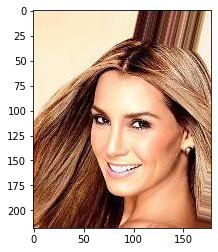

In [ ]:
img = Image.open('data_faces/img_align_celeba/000001.jpg')
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

In [ ]:
class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['Male'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [ ]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally

custom_transform = transforms.Compose([transforms.CenterCrop((178, 178)),
                                       transforms.Resize((128, 128)),
                                       #transforms.Grayscale(),                                       
                                       #transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])

train_dataset = CelebaDataset(csv_path='celeba-gender-train.csv',
                              img_dir='data_faces/img_align_celeba/',
                              transform=custom_transform)

valid_dataset = CelebaDataset(csv_path='celeba-gender-valid.csv',
                              img_dir='data_faces/img_align_celeba/',
                              transform=custom_transform)

test_dataset = CelebaDataset(csv_path='celeba-gender-test.csv',
                             img_dir='data_faces/img_align_celeba/',
                             transform=custom_transform)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        time.sleep(1)
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1 | Batch index: 0 | Batch size: 256
Epoch: 2 | Batch index: 0 | Batch size: 256


In [ ]:
##########################
### MODEL
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet18(num_classes):
    """Constructs a ResNet-18 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[2, 2, 2, 2],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

In [ ]:
torch.manual_seed(RANDOM_SEED)

##########################
### COST AND OPTIMIZER
##########################



model = resnet18(NUM_CLASSES)


#### DATA PARALLEL START ####
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = nn.DataParallel(model)
#### DATA PARALLEL END ####


model.to(DEVICE)



cost_fn = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return float(correct_pred)/num_examples * 100
    

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.type(torch.LongTensor)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = cost_fn(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%% ' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(model, train_loader, device=DEVICE)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 001/003 | Batch 0000/0224 | Cost: 0.6935
Epoch: 001/003 | Batch 0050/0224 | Cost: 0.0631
Epoch: 001/003 | Batch 0100/0224 | Cost: 0.0402
Epoch: 001/003 | Batch 0150/0224 | Cost: 0.0756
Epoch: 001/003 | Batch 0200/0224 | Cost: 0.0545
Epoch: 001/003 | Train: 98.711% 
Time elapsed: 5.08 min
Epoch: 002/003 | Batch 0000/0224 | Cost: 0.0415
Epoch: 002/003 | Batch 0050/0224 | Cost: 0.0353
Epoch: 002/003 | Batch 0100/0224 | Cost: 0.0525
Epoch: 002/003 | Batch 0150/0224 | Cost: 0.0585
Epoch: 002/003 | Batch 0200/0224 | Cost: 0.0407
Epoch: 002/003 | Train: 98.355% 
Time elapsed: 10.17 min
Epoch: 003/003 | Batch 0000/0224 | Cost: 0.0184
Epoch: 003/003 | Batch 0050/0224 | Cost: 0.0621
Epoch: 003/003 | Batch 0100/0224 | Cost: 0.0384
Epoch: 003/003 | Batch 0150/0224 | Cost: 0.0197
Epoch: 003/003 | Batch 0200/0224 | Cost: 0.0426
Epoch: 003/003 | Train: 98.351% 
Time elapsed: 15.24 min
Total Training Time: 15.24 min


In [ ]:
'''
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))
'''

"\nwith torch.set_grad_enabled(False): # save memory during inference\n    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))\n"

In [ ]:
torch.save(model.state_dict(), model_name)